In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

import matplotlib.font_manager as fm

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

In [2]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error

In [3]:
plt.rc('font', family='Malgun Gothic') # 폰트 지정
plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정
%config InlineBackend.figure_format='retina' # 그래프 글씨 뚜렷

In [4]:
import warnings
warnings.filterwarnings('ignore')

-----------------------

# 1. 데이터 불러오기

In [5]:
df = pd.read_csv('./dataset/final_data/steels.csv', index_col="날짜")
df.head()

,레이블,WTI,환율,VIX,PBR,통화량,기준금리,소비자물가지수,수입금액지수,수출금액지수,...,미국경제성장률,OBV,ADI,EOM,MFI,MACD,ADX,RSI,ATR,ev_ebitda
날짜,,,,,,,,,,,,,,,,,,,,,
2013-06-04,down,93.31,1118.8,16.27,0.76,1884068.8,2.5,92.71,112.94,104.47,...,0.1,3526419.0,-1557.79,25318.28,69.87,13.68,29.86,89.46,18.78,0.148385
2013-06-05,down,93.74,1122.4,17.50,0.75,1884068.8,2.5,92.71,112.94,104.47,...,0.1,3522869.0,-2911.12,45243.87,67.52,11.13,29.01,84.53,18.53,0.149774
2013-06-07,neutral,96.03,1118.2,15.14,0.74,1884068.8,2.5,92.71,112.94,104.47,...,0.1,3519549.0,-2189.60,96272.03,65.20,9.36,28.40,79.29,18.03,0.150479
2013-06-10,neutral,95.77,1097.1,15.44,0.74,1884068.8,2.5,92.71,112.94,104.47,...,0.1,3516689.0,1556.17,-2223.92,63.11,8.02,28.05,69.94,17.82,0.151667
2013-06-11,neutral,95.38,1097.1,17.07,0.74,1884068.8,2.5,92.71,112.94,104.47,...,0.1,3518779.0,2445.82,-2232.83,65.76,6.51,28.68,71.71,18.40,0.151907


------------------------

# 2. 데이터 전처리

## EDA

- 데이터 정보 확인

In [6]:
# df.info()

## 결측치 제거

- 결측치 제거(공휴일)
- PER 결측치 0으로 대체

In [7]:
# 코드 생략

- 결측치 제거 확인

In [8]:
# df.info()

## 기초통계량 확인

- 상대적으로 값이 큰(평균이 1000이 넘는) 피쳐는 로그 변환 실시가 필요함

In [9]:
# df.describe()

##  로그 변환

In [10]:
# # 통화량, 환율 로그 변환
# feature_to_log_transform = ['통화량', '환율']
# df[feature_to_log_transform] = np.log(df[feature_to_log_transform])

In [11]:
# df.describe()

## 정규성 확인 (for scaling method selection)
- 환율, PBR, 수입금액지수, 수출금액지수, 경제심리지수, 경지종합지수, 실업률, 고용률 : 정규성 o -> 최소 최대 스케일링 적용
- WTI, VIX, PER, 통화량, 기준금리, 소비자물가지수, 한국경제성장률, 미국경제성장률 : 정규성 x -> 표준화 스케일링 적용

In [12]:
# df.hist(figsize=(15,15))

## Test-Train-Split

In [13]:
encoder = LabelEncoder()
df['레이블']= encoder.fit_transform(df['레이블'])
df['레이블'].value_counts()

레이블
0    1055
2     720
1     600
Name: count, dtype: int64

In [14]:
X = df.drop('레이블',axis=1)
y = df[['레이블']]

In [15]:
X_train,X_test,y_train,y_test= train_test_split(X, y, test_size=0.3, stratify=y, random_state=42) 

In [16]:
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))
print(y_train.value_counts())
print(y_test.value_counts())

1662
713
1662
713
레이블
0      738
2      504
1      420
Name: count, dtype: int64
레이블
0      317
2      216
1      180
Name: count, dtype: int64


In [17]:
# train_data = pd.concat([X_train,y_train], axis=1)
# test_data= pd.concat([X_test,y_test],axis=1 )

## 이상치

- Box Plot
    - train_data의 이상치 확인 (test_data는 과적합 방지 차원에서 건들지 않음)
    - 추가로 스케일링이 필요함을 확인할 수 있음

In [18]:
# plt.figure(figsize=(26, 13))
# X_train.boxplot()
# plt.title('Box Plot of Features')
# plt.ylabel('Values')
# plt.xlabel('Features')
# plt.show()

이상치는 존재하지만, 후보 피처 모두 실제 경제 상황을 나타내는 피처들이기 때문에 제거하지 않음. (맞는 논리?)

--------------------

# 3. 스케일링
- 분류 모델에서 스케일링이 필수적인 단계는 아니지만 성능을 조금이라도 높일 가능성과, 컴퓨팅 리소스 낭비 방지 차원에서 실시

In [19]:
# X_train = train_data.drop('레이블', axis=1)
# y_train = train_data[['레이블']]

# X_test = test_data.drop('레이블', axis=1)
# y_test = test_data[['레이블']]

- 스케일링
    - 환율, PBR, 수입금액지수, 수출금액지수, 경제심리지수, 경기종합지수, 실업률, 고용률 : 정규성 o 
    -> 표준화 스케일링 적용
    - WTI, VIX, PER, 통화량, 기준금리, 소비자물가지수, 한국경제성장률, 미국경제성장률 : 정규성 x 
    -> 최소 최대 스케일링 적용

In [20]:
# # 표준화 (StandardScaler)
# features_to_standardize = ['WTI', 'VIX', 'PER', '통화량', '기준금리', '소비자물가지수', '한국경제성장률', '미국경제성장률']
# scaler_standardize = StandardScaler()
# X_train[features_to_standardize] = scaler_standardize.fit_transform(X_train[features_to_standardize])
# X_test[features_to_standardize] = scaler_standardize.transform(X_test[features_to_standardize])

In [21]:
df.columns

Index(['레이블', 'WTI', '환율', 'VIX', 'PBR', '통화량', '기준금리', '소비자물가지수', '수입금액지수',
       '수출금액지수', '경제심리지수', '경기종합지수', '실업률', '고용률', '한국경제성장률', '미국경제성장률', 'OBV',
       'ADI', 'EOM', 'MFI', 'MACD', 'ADX', 'RSI', 'ATR', 'ev_ebitda'],
      dtype='object')

In [22]:
# 최소-최대 스케일링 (Min-Max Scaling)
features_to_minmax = ['환율', 'PBR', '수입금액지수', '수출금액지수', '경제심리지수', '경기종합지수', '실업률', '고용률','WTI', 'VIX', 'ev_ebitda', '통화량', '기준금리', '소비자물가지수', '한국경제성장률', '미국경제성장률', 'OBV', 'ADI', 'EOM', 'MFI', 'MACD', 'ADX', 'RSI', 'ATR']
scaler_standard = StandardScaler()
X_train[features_to_minmax] = scaler_standard.fit_transform(X_train[features_to_minmax])
X_test[features_to_minmax] = scaler_standard.transform(X_test[features_to_minmax])

In [23]:
X_train

,WTI,환율,VIX,PBR,통화량,기준금리,소비자물가지수,수입금액지수,수출금액지수,경제심리지수,...,미국경제성장률,OBV,ADI,EOM,MFI,MACD,ADX,RSI,ATR,ev_ebitda
날짜,,,,,,,,,,,,,,,,,,,,,
2022-09-20,0.882410,3.143217,1.206823,-1.011716,1.759079,1.251818,2.173095,2.108095,1.819764,0.143499,...,0.137758,1.938022,0.129371,-0.000212,1.288755,0.217485,0.146430,1.004723,0.704783,-1.518949
2018-09-06,0.131420,-0.414277,-0.462947,-0.293990,-0.113177,-0.123506,0.270832,-0.322276,0.651078,0.098045,...,0.086698,-0.967767,-0.166857,-0.001397,0.262879,1.234251,0.088604,-0.407695,0.175628,0.234411
2020-12-22,-0.802816,-0.626672,0.815742,-0.612980,0.831423,-1.498831,0.294640,0.106791,0.579158,-0.856482,...,0.239878,-1.090508,-2.322306,0.000498,-0.991444,-0.923144,0.361546,-0.980943,1.109045,-0.792710
2021-08-24,0.121064,0.233242,-0.119917,0.902220,1.300670,-1.154999,0.823229,0.938109,1.095732,1.537413,...,0.086698,-0.235156,1.229061,-0.003982,-0.232445,0.102469,-0.461907,-1.282438,1.368692,1.683573
2014-06-10,1.778375,-1.739264,-0.951466,0.902220,-1.216867,1.251818,-1.033820,-0.220632,-0.350950,0.385919,...,0.393058,0.299353,-0.014220,-0.596769,0.149723,-0.933353,2.605222,-0.877140,-1.309951,-0.447357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-09-21,-0.878455,-0.439780,-0.643139,-0.054748,-0.568752,-0.467337,-0.597189,-1.203334,-1.126847,0.022289,...,0.035638,0.297562,-0.014501,-2.700175,-0.987174,-0.364399,0.018055,-0.387284,-0.889256,0.530825
2018-03-15,-0.164834,-1.140790,-0.204006,0.503483,-0.236492,-0.123506,-0.050253,0.105926,0.688420,0.522280,...,0.086698,0.050828,0.251601,-0.000805,0.704828,0.501962,-0.105694,0.853684,0.243005,-0.038709
2014-01-03,1.310582,-1.310157,-0.581740,1.460451,-1.322071,1.251818,-1.146964,0.143556,-0.438774,0.491977,...,-0.474963,0.299045,-0.015049,0.514259,0.178546,0.209318,-1.321212,0.580181,-1.249148,-0.649904


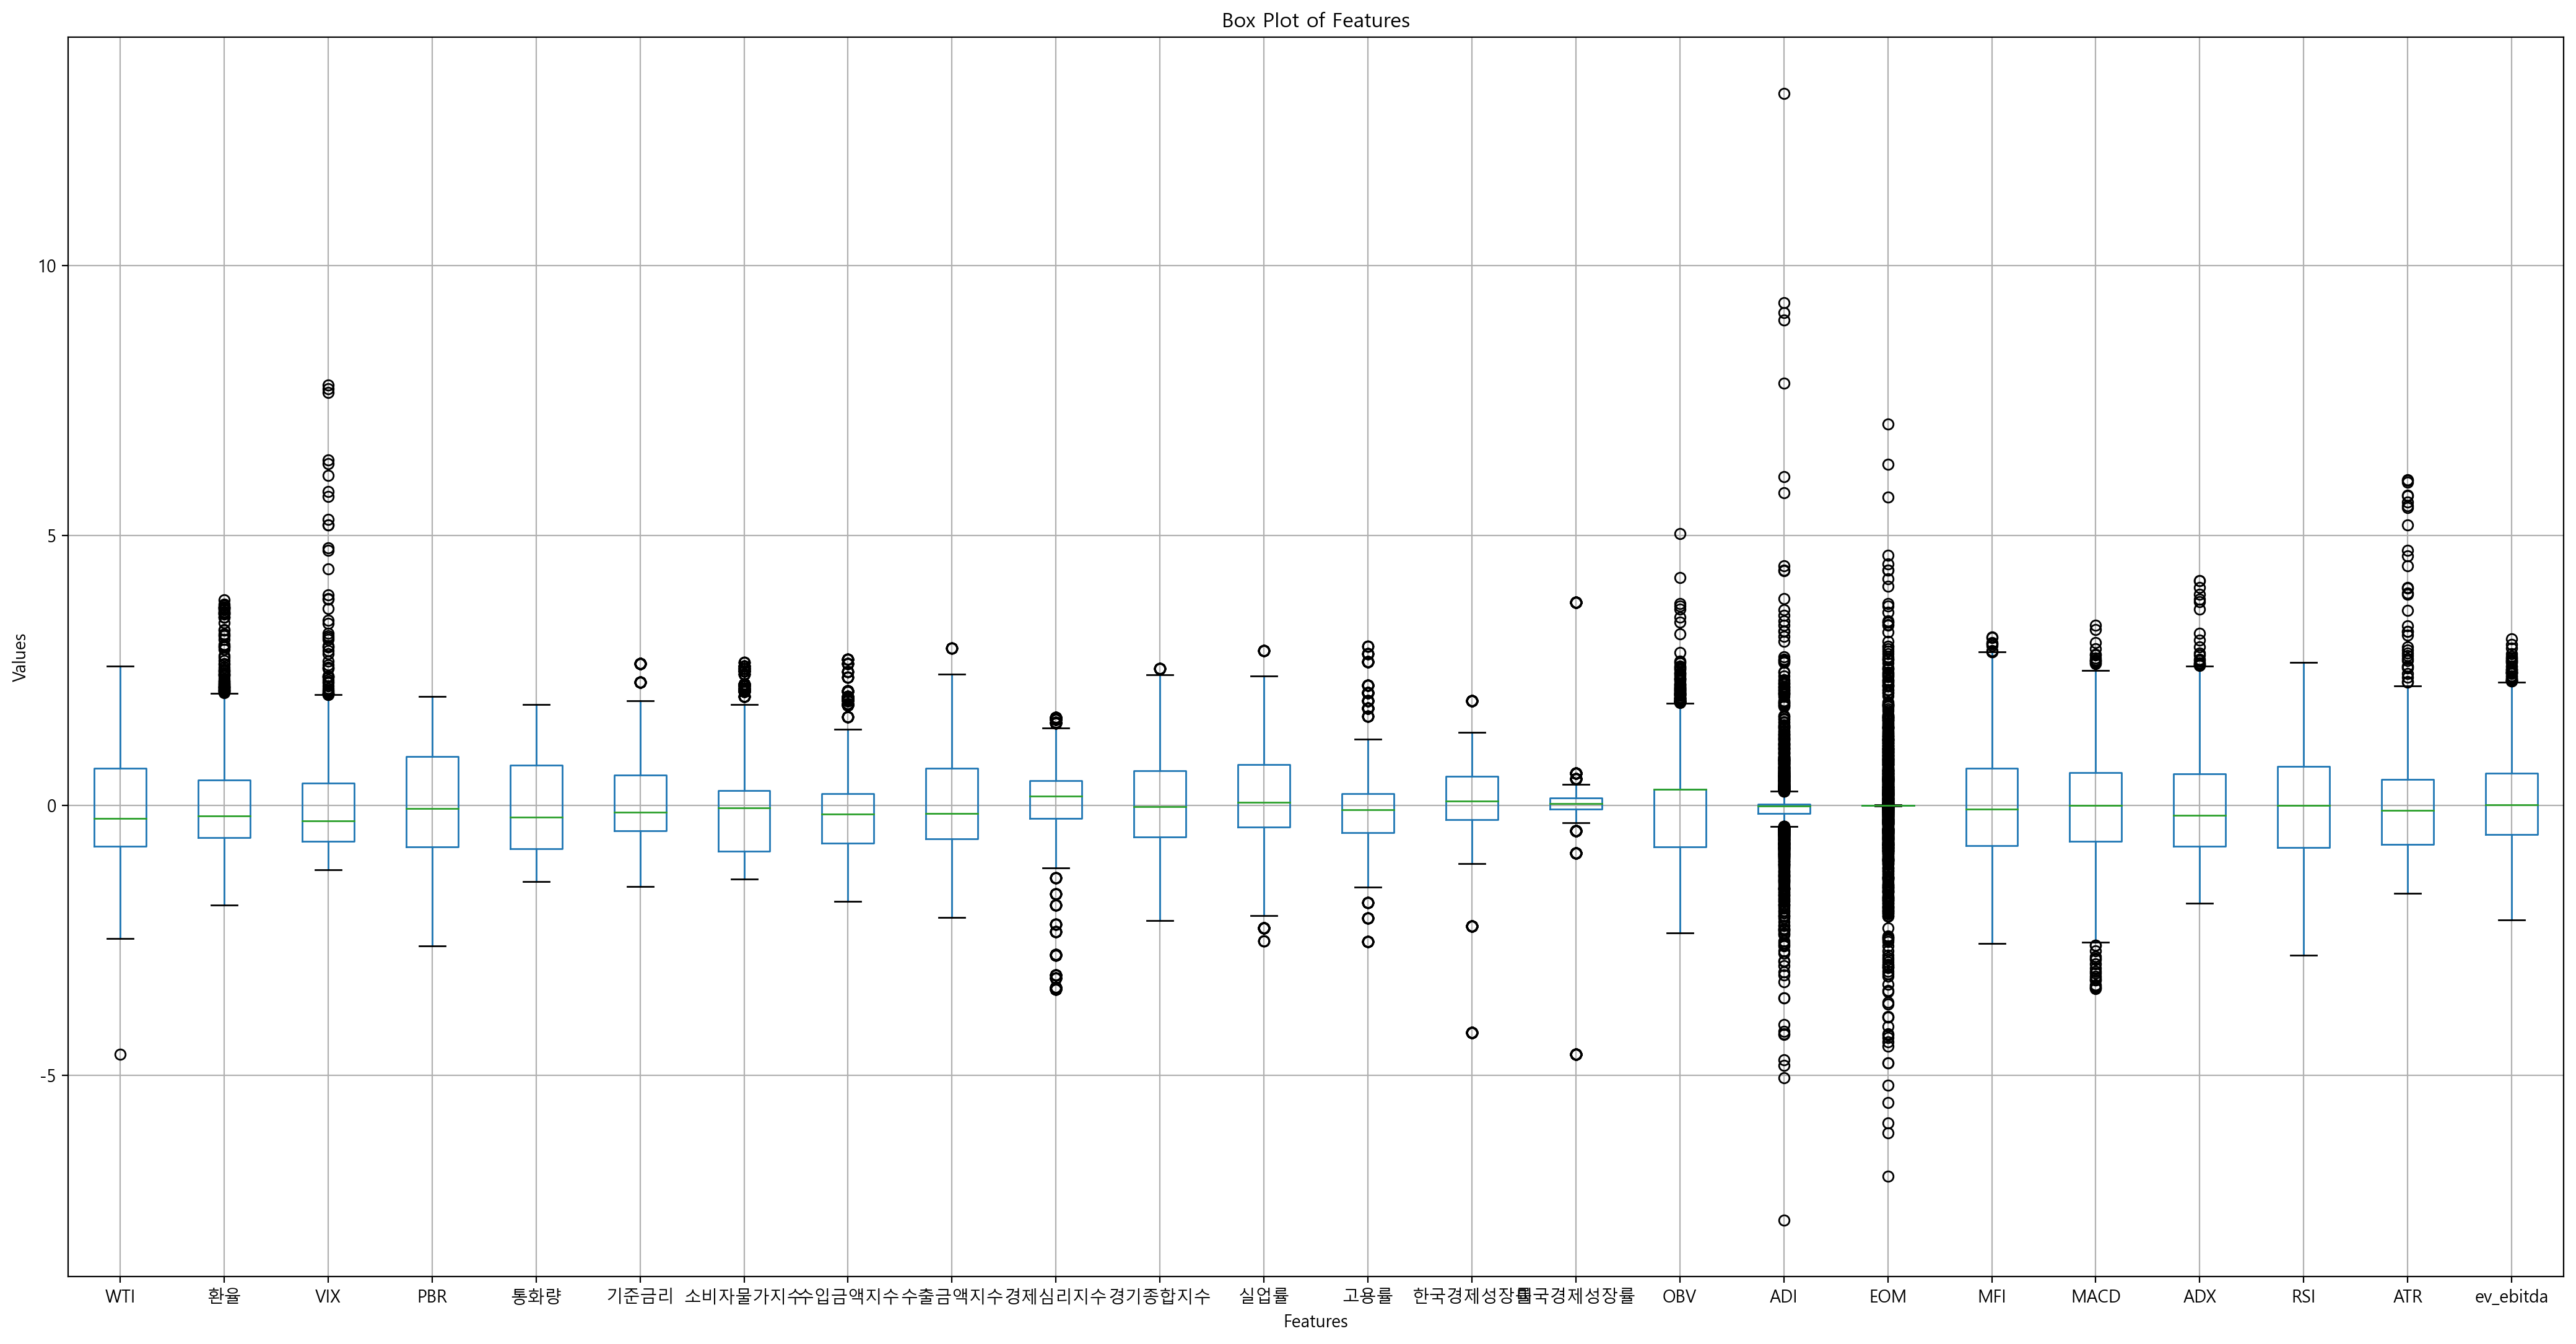

In [24]:
# 스케일링 결과 확인

plt.figure(figsize=(26, 13))
X_train.boxplot()
plt.title('Box Plot of Features')
plt.ylabel('Values')
plt.xlabel('Features')
plt.show()

## Q-Q plot

In [25]:
# import statsmodels.api as sm
# from scipy import stats

In [26]:
# # Q-Q plot 생성
# sm.qqplot(X_train, line='s')  # line='s'는 기준 선을 표시합니다.

# # 그래프 제목 및 레이블 설정
# plt.title('Q-Q Plot')
# plt.xlabel('Theoretical Quantiles')
# plt.ylabel('Sample Quantiles')

# # 그래프 표시
# plt.show()

In [27]:
# feature_names = [X_train.columns]

# # Loop through each feature
# for i, feature_name in enumerate(feature_names):
#     # Create a QQ plot for the current feature
#     sm.qqplot(X_train[feature_name], line='s')
#     plt.title(f'QQ Plot for {feature_name}')
#     plt.show()

---------------

## 4. 피처 셀렉션

- 먼저 feature_importance로 중요한 피처 순서 확인 -> 일별 데이터의 중요도가 높은 것으로 보아 후보 피처 선정의 한계점이 나타남
- 모델 기반 피처 선정 이후 이 값과 비교하여 타당성 확인

In [28]:
# X_train

In [29]:
# Feature_Importances

rfc = RandomForestClassifier(random_state=42)

rfc.fit(X_train, y_train)

rfc.feature_importances_

ftr_importances = pd.Series(rfc.feature_importances_, index=X_train.columns)
sorted_feature_importance = ftr_importances.sort_values(ascending=True)
data = sorted_feature_importance
importance = pd.DataFrame(data, columns=['feature importances'])
importance

,feature importances
실업률,0.020635
EOM,0.021096
ADI,0.021510
미국경제성장률,0.022596
기준금리,0.023077
한국경제성장률,0.025014
RSI,0.030446
경기종합지수,0.031975
MFI,0.037751
소비자물가지수,0.037811


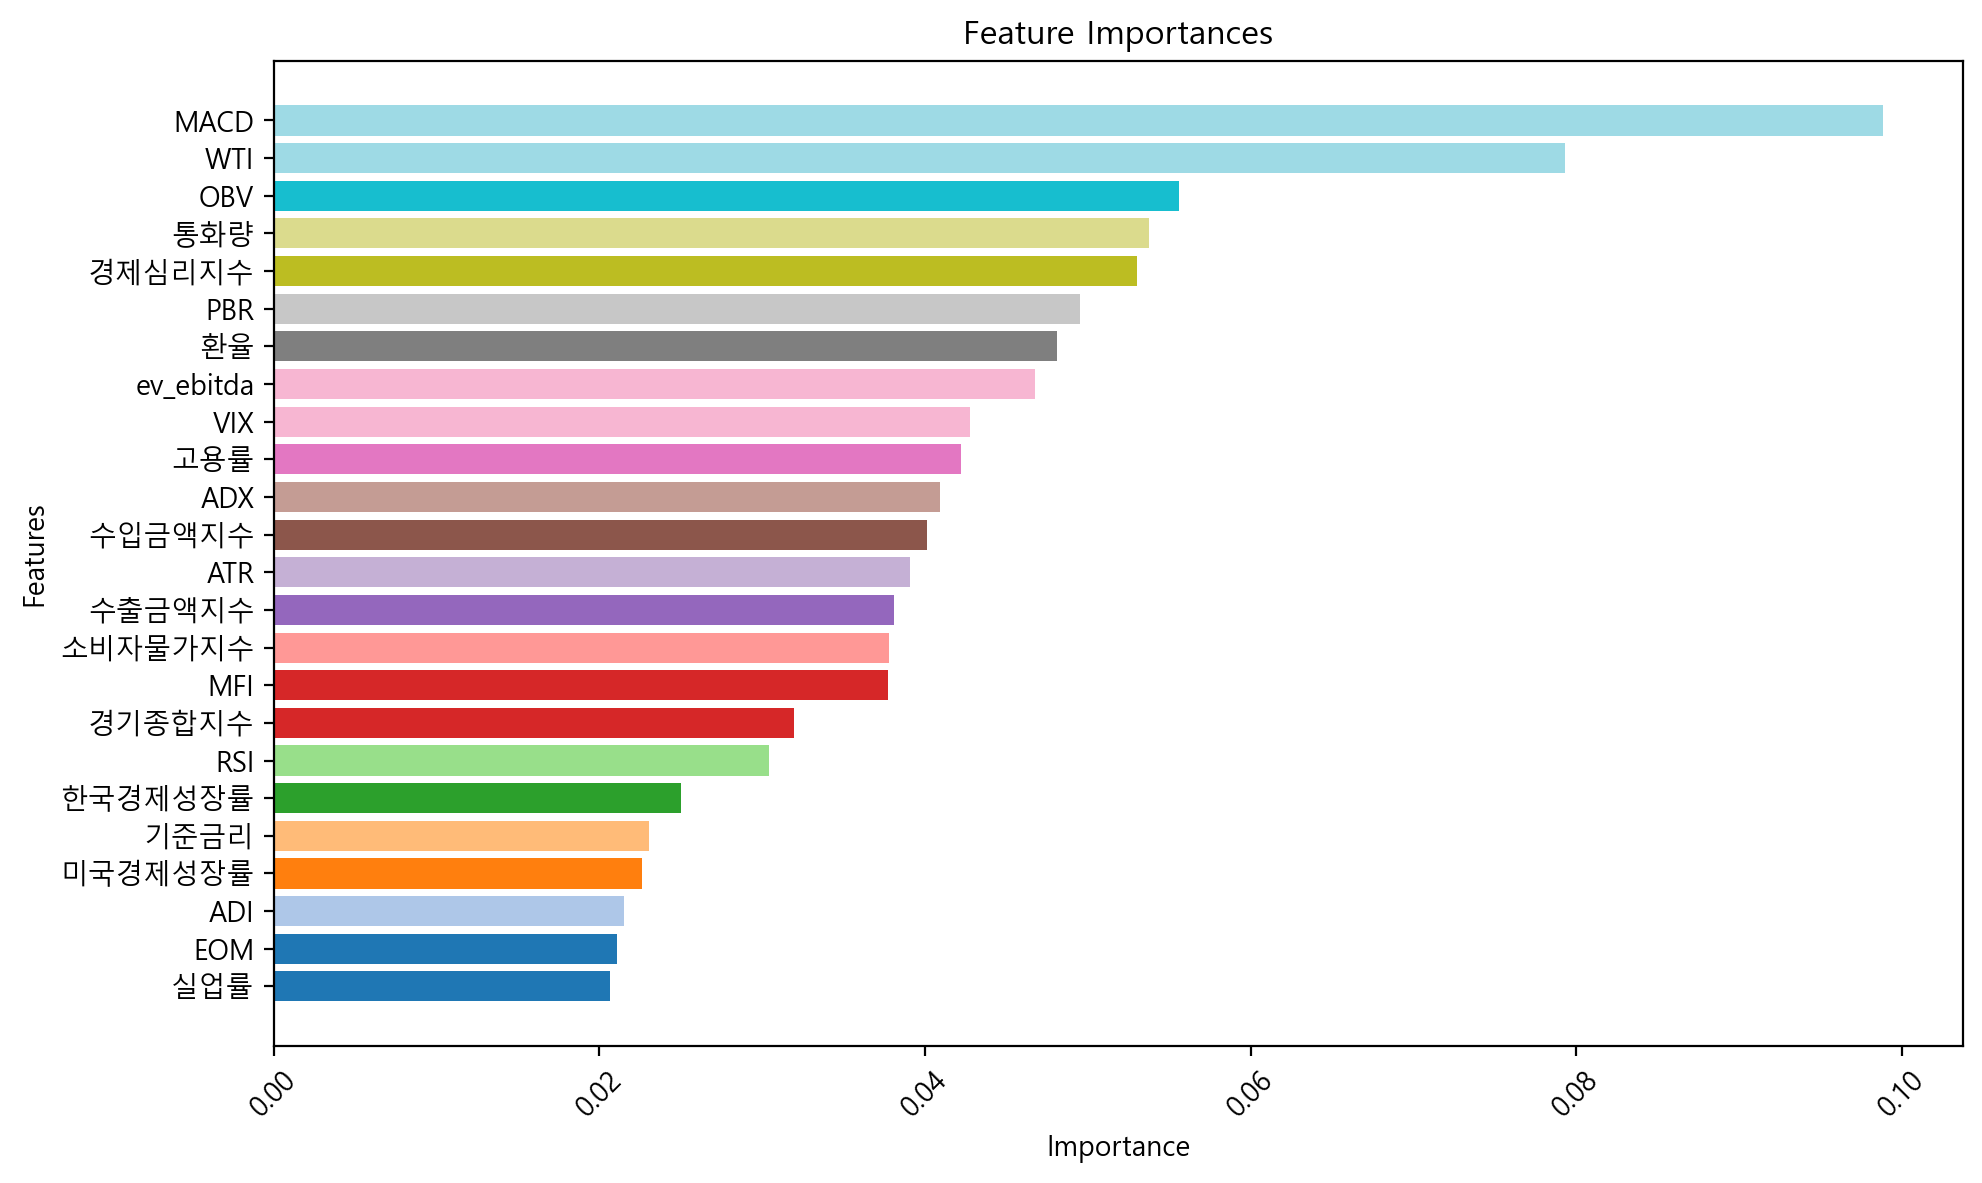

In [30]:
plt.figure(figsize=(10, 6))
colors = plt.cm.tab20(np.linspace(0, 1, len(importance)))

plt.barh(importance.index, importance['feature importances'], color=colors)  # Changed to barh for horizontal bar chart
plt.ylabel('Features')  # Changed to 'Features' for Y-axis label
plt.xlabel('Importance')  # Changed to 'Importance' for X-axis label
plt.title('Feature Importances')

# Rotating x labels for better visibility if needed
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


## Feature 갯수 구하기 위한 Logit

### 질문 : logit.fit할 때 logit.fit(X, y) or logit.fit(X_train, y_train) 무엇이 맞나요?

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
import statsmodels.api as sm
import numpy as np
lr_clf = LogisticRegression()


logit = SelectFromModel(LogisticRegression())
logit.fit(X_train, y_train)
logit_support = logit.get_support()
lr_feature = X_train.loc[:,logit_support].columns.tolist()

In [32]:
print(lr_feature)
print(len(lr_feature))

['환율', 'PBR', '통화량', '소비자물가지수', '수입금액지수', '수출금액지수', '경제심리지수', '한국경제성장률', '미국경제성장률', 'MACD']
10


## 피처 선정

- Filter 방법은 분류 모델 특성 상 통계 기법의 중요도가 떨어지므로 생략

1. 전진선택법 by Wrapper
2. 후진선택법 by Wrapper
3. Stepwise선택법 by Wrapper
4. Lasso by embedded
5. Ridge by embedded
6. ElasticNet by embedded

In [33]:
# 1. 전진선택법 by Wrapper



selected_features = []
best_score = 0

while len(selected_features) < X.shape[1]:
    best_feature = None
    best_model = None
    best_score_local = 0

    for feature in X_train.columns:
        if feature not in selected_features:
            features = selected_features + [feature]
            X_train_selected = X_train[features]
            X_val_selected = X_test[features]

            model = LogisticRegression()
            model.fit(X_train_selected, y_train)
            score = model.score(X_val_selected, y_test)

            if score > best_score_local:
                best_score_local = score
                best_feature = feature
                best_model = model

    if best_score_local > best_score:
        selected_features.append(best_feature)
        best_score = best_score_local
        print(f"Selected feature: {best_feature}, Accuracy: {best_score:.4f}")

    else:
        break

print("\nForward selected features:")
Forward = selected_features

Selected feature: WTI, Accuracy: 0.5470
Selected feature: MACD, Accuracy: 0.5764
Selected feature: 경제심리지수, Accuracy: 0.6101
Selected feature: 한국경제성장률, Accuracy: 0.6255
Selected feature: 기준금리, Accuracy: 0.6564
Selected feature: 통화량, Accuracy: 0.6634
Selected feature: 수입금액지수, Accuracy: 0.6648
Selected feature: ADX, Accuracy: 0.6690
Selected feature: RSI, Accuracy: 0.6816

Forward selected features:


In [34]:
# 2. 후진선택법 by Wrapper



selected_features = X_train.columns.tolist()
best_score = 0

while len(selected_features) > 0:
    worst_feature = None
    best_model = None
    best_score_local = 0

    for feature in selected_features:
        features = selected_features.copy()
        features.remove(feature)

        X_train_selected = X_train[features]
        X_val_selected = X_test[features]

        model = LogisticRegression()
        model.fit(X_train_selected, y_train)
        score = model.score(X_val_selected, y_test)

        if score > best_score_local:
            best_score_local = score
            worst_feature = feature
            best_model = model

    if best_score_local > best_score:
        selected_features.remove(worst_feature)
        best_score = best_score_local
        print(f"Removed feature: {worst_feature}, Accuracy: {best_score:.4f}")

    else:
        break

print("\nFinal selected features:")
Backward = selected_features

Removed feature: 기준금리, Accuracy: 0.7041
Removed feature: 수출금액지수, Accuracy: 0.7083
Removed feature: EOM, Accuracy: 0.7139
Removed feature: ADI, Accuracy: 0.7153

Final selected features:


In [35]:
# 3. Stepwise선택법 by Wrapper



selected_features = []
best_score = 0

# Forward step
while len(selected_features) < X.shape[1]:
    best_feature = None
    best_model = None
    best_score_local = 0

    for feature in X_train.columns:
        if feature not in selected_features:
            features = selected_features + [feature]
            X_train_selected = X_train[features]
            X_val_selected = X_test[features]

            model = LogisticRegression()
            model.fit(X_train_selected, y_train)
            score = model.score(X_val_selected, y_test)

            if score > best_score_local:
                best_score_local = score
                best_feature = feature
                best_model = model

    if best_score_local > best_score:
        selected_features.append(best_feature)
        best_score = best_score_local
        print(f"Selected feature: {best_feature}, Accuracy: {best_score:.4f}")

    else:
        break

# Backward step
while len(selected_features) > 0:
    worst_feature = None
    best_model = None
    best_score_local = 0

    for feature in selected_features:
        features = selected_features.copy()
        features.remove(feature)

        X_train_selected = X_train[features]
        X_val_selected = X_test[features]

        model = LogisticRegression()
        model.fit(X_train_selected, y_train)
        score = model.score(X_val_selected, y_test)

        if score > best_score_local:
            best_score_local = score
            worst_feature = feature
            best_model = model

    if best_score_local > best_score:
        selected_features.remove(worst_feature)
        best_score = best_score_local
        print(f"Removed feature: {worst_feature}, Accuracy: {best_score:.4f}")

    else:
        break

print("\nFinal selected features:")
Stepwise = selected_features

Selected feature: WTI, Accuracy: 0.5470
Selected feature: MACD, Accuracy: 0.5764
Selected feature: 경제심리지수, Accuracy: 0.6101
Selected feature: 한국경제성장률, Accuracy: 0.6255
Selected feature: 기준금리, Accuracy: 0.6564
Selected feature: 통화량, Accuracy: 0.6634
Selected feature: 수입금액지수, Accuracy: 0.6648
Selected feature: ADX, Accuracy: 0.6690
Selected feature: RSI, Accuracy: 0.6816

Final selected features:


In [36]:
# 4. Lasso

lasso_model = LogisticRegression()
param_grid = {'penalty' : ['l1'], 
                'C' : [0.001, 0.01, 0.1, 1, 2, 5, 10],
                'solver' : ['liblinear']}

grid_search = GridSearchCV(lasso_model, param_grid=param_grid, return_train_score=True, cv=5)
grid_search.fit(X_train, y_train)

df = pd.DataFrame(grid_search.cv_results_)
df = df.sort_values(by=['rank_test_score'], ascending=True)
df[['params', 'mean_train_score', 'mean_test_score', 'rank_test_score']]
print('GridSearchCV 최적 파라미터:', grid_search.best_params_)
print('GridSearchCV 최고 정확도:{0:.4f}'.format(grid_search.best_score_))

GridSearchCV 최적 파라미터: {'C': 2, 'penalty': 'l1', 'solver': 'liblinear'}
GridSearchCV 최고 정확도:0.7004


In [71]:
lasso_best = LogisticRegression(C=0.0128, penalty='l1', solver='liblinear').fit(X_train, y_train)

df_lasso = pd.DataFrame()
df_lasso['feature'] = X_train.columns
df_lasso['coef'] = lasso_best.coef_[0]
df_lasso.drop(df_lasso[df_lasso['coef']==0].index, inplace=True)
df_lasso

,feature,coef
0,WTI,0.061103
1,환율,-0.001360
5,수입금액지수,0.122794
6,경제심리지수,0.331984
9,MACD,0.787576


In [72]:
# 라쏘에서 선택된 피처
lasso = df_lasso['feature'].values.tolist()
print('Lasso에서 선택된 피처 수 {0:1.0f}'.format(len(df_lasso)), '개')
lasso

Lasso에서 선택된 피처 수 5 개


['WTI', '환율', '수입금액지수', '경제심리지수', 'MACD']

## 최종 피처 선정

In [73]:
list_Forward = list(Forward)
list_Backward = list(Backward)
list_Stepwise = list(Stepwise)
list_lasso = list(lasso)
list_col_all = X_train.columns

In [74]:
def func_Forward(x):
    if x in list_Forward:
        return 1
    else:
        return 0
    
def func_Backward(x):
    if x in list_Backward:
        return 1
    else:
        return 0


def func_Stepwise(x):
    if x in list_Stepwise:
        return 1
    else:
        return 0
    
def func_lasso(x):
    if x in list_lasso:
        return 1
    else:
        return 0
    

In [75]:
# 2번 선택된 Feature

feature_counts = pd.DataFrame()
feature_counts['Feature'] = list_col_all
feature_counts['Forward'] = list_col_all.map(func_Forward)
feature_counts['Backward'] = list_col_all.map(func_Backward)
feature_counts['Stepwise'] = list_col_all.map(func_Stepwise)
feature_counts['lasso'] = list_col_all.map(func_lasso)


feature_counts["total"] = feature_counts["Forward"]+feature_counts['Backward']+feature_counts["Stepwise"]+feature_counts["lasso"]
feature_final = feature_counts[feature_counts["total"]>=2]
list_feature_final = list(feature_final["Feature"])
print("선택된 피쳐수 :", len(list_feature_final))
feature_final

선택된 피쳐수 : 10


,Feature,Forward,Backward,Stepwise,lasso,total
0,WTI,1,1,1,1,4
1,환율,0,1,0,1,2
3,통화량,1,1,1,0,3
4,기준금리,1,0,1,0,2
5,수입금액지수,1,1,1,1,4
6,경제심리지수,1,1,1,1,4
7,한국경제성장률,1,1,1,0,3
9,MACD,1,1,1,1,4
10,ADX,1,1,1,0,3
11,RSI,1,1,1,0,3


In [42]:
# 3번 선택된 Feature

# feature_counts = pd.DataFrame()
# feature_counts['Feature'] = list_col_all
# feature_counts['Forward'] = list_col_all.map(func_Forward)
# feature_counts['Backward'] = list_col_all.map(func_Backward)
# feature_counts['Stepwise'] = list_col_all.map(func_Stepwise)
# feature_counts['lasso'] = list_col_all.map(func_lasso)


# feature_counts["total"] = feature_counts["Forward"]+feature_counts['Backward']+feature_counts["Stepwise"]+feature_counts["lasso"]
# feature_final = feature_counts[feature_counts["total"]>=3]
# list_feature_final = list(feature_final["Feature"])
# print("선택된 피쳐수 :", len(list_feature_final))
# # feature_final

In [43]:
# # 4번 선택된 Feature

# feature_counts = pd.DataFrame()
# feature_counts['Feature'] = list_col_all
# feature_counts['Forward'] = list_col_all.map(func_Forward)
# feature_counts['Backward'] = list_col_all.map(func_Backward)
# feature_counts['Stepwise'] = list_col_all.map(func_Stepwise)
# feature_counts['lasso'] = list_col_all.map(func_lasso)
# feature_counts['ridge'] = list_col_all.map(func_ridge)

# feature_counts["total"] = feature_counts["Forward"]+feature_counts['Backward']+feature_counts["Stepwise"]+feature_counts["lasso"]+feature_counts["ridge"]
# feature_final = feature_counts[feature_counts["total"]>=4]
# list_feature_final = list(feature_final["Feature"])
# print("선택된 피쳐수 :", len(list_feature_final))
# feature_final

In [44]:
# # 5번 선택된 Feature

# feature_counts = pd.DataFrame()
# feature_counts['Feature'] = list_col_all
# feature_counts['Forward'] = list_col_all.map(func_Forward)
# feature_counts['Backward'] = list_col_all.map(func_Backward)
# feature_counts['Stepwise'] = list_col_all.map(func_Stepwise)
# feature_counts['lasso'] = list_col_all.map(func_lasso)
# feature_counts['ridge'] = list_col_all.map(func_ridge)

# feature_counts["total"] = feature_counts["Forward"]+feature_counts['Backward']+feature_counts["Stepwise"]+feature_counts["lasso"]+feature_counts["ridge"]
# feature_final = feature_counts[feature_counts["total"]>=5]
# list_feature_final = list(feature_final["Feature"])
# print("선택된 피쳐수 :", len(list_feature_final))
# feature_final

In [76]:
final_ftr = feature_final['Feature'].values

----------------------------------------

## 5. 다중공선성 확인 (생략 가능 단계)

- 분류 모델 특성 상 독립변수 간의 상관관계가 중요하지 않지만, <br> 이후 로지스틱회귀, SVM 모델도 사용할 것을 감안하여 다중공선성 확인

In [46]:
# X_train = X_train[lr_feature]
# X_test = X_test[lr_feature]

In [77]:
X_train = X_train[final_ftr]
X_test = X_test[final_ftr]

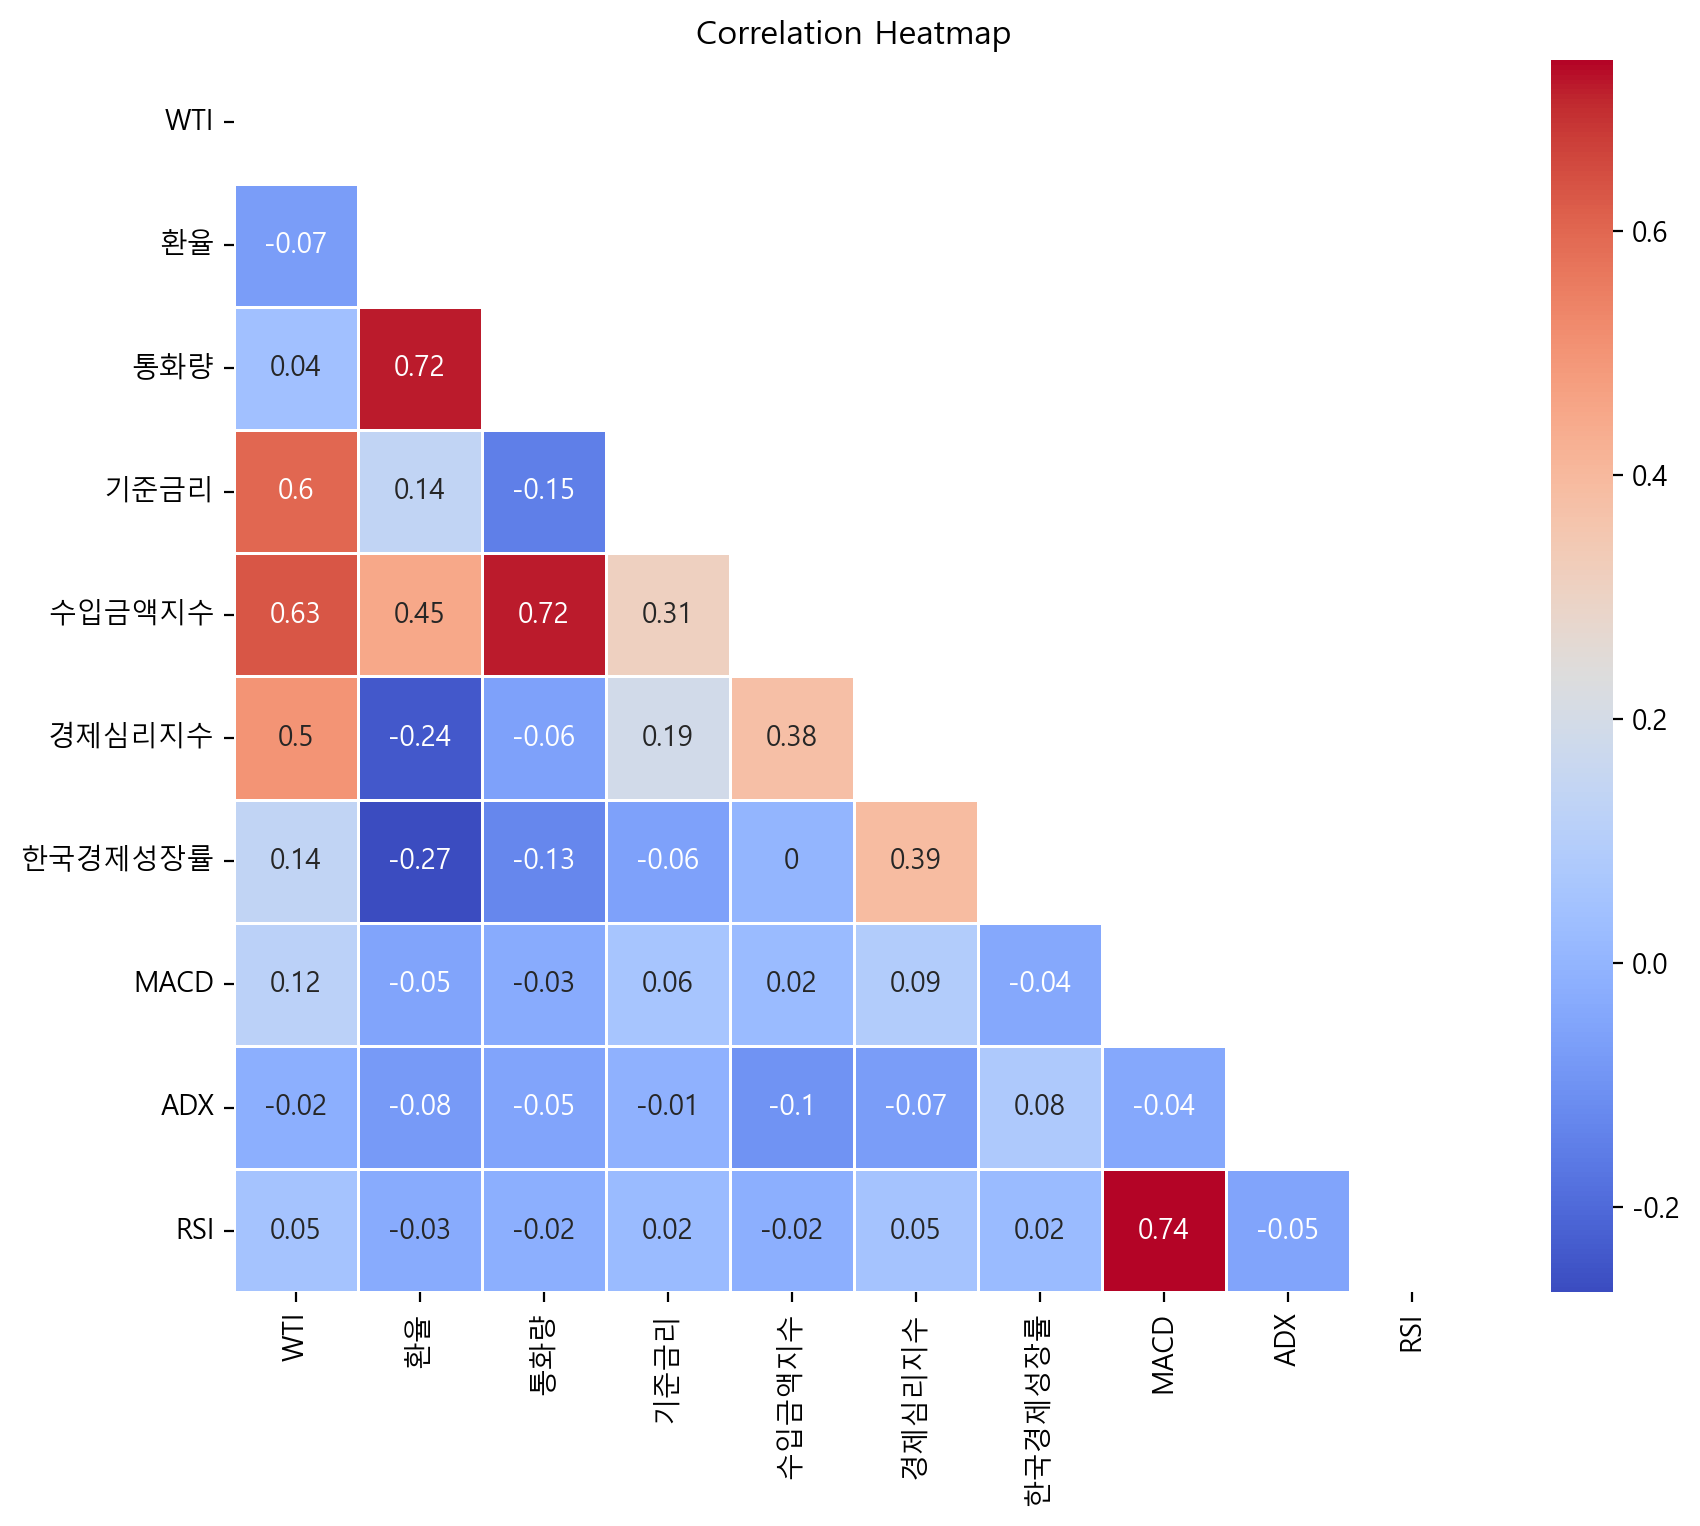

In [78]:
# 상관관계 행렬을 구합니다.
corr = X_train.corr().round(2)

mask = np.zeros_like(corr, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

# 히트맵을 그립니다.
plt.figure(figsize=(10, 8))
sns.heatmap(data=corr, annot=True, cmap='coolwarm', linewidths=.5, mask=mask)
plt.title('Correlation Heatmap')
plt.show()

In [79]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# extract effective features using variance inflation factor
vif = pd.DataFrame()

# variance_inflation_factor(X, i) : Xi를 x나머지로 회귀분석한 후 VIF값을 구한것. 즉 xi의 vif값. 즉 이값이 높을수록 종속성이 높다는 뜻

vif['VIF_Factor'] = [variance_inflation_factor(X_train.values, i) 
                     for i in range(X_train.shape[1])]
vif['Feature'] = X_train.columns
vif.sort_values(by='VIF_Factor', ascending=False)

,VIF_Factor,Feature
4,11.054193,수입금액지수
2,9.881829,통화량
0,4.373048,WTI
1,3.380486,환율
3,2.764843,기준금리
7,2.281547,MACD
9,2.233236,RSI
5,2.048779,경제심리지수
6,1.301255,한국경제성장률
8,1.051155,ADX


-----------------------

## 6. 모델링

In [80]:
def model_basic(X_train, y_train, X_test, y_test):
    models = [
        LogisticRegression(),
        DecisionTreeClassifier(),
        SVC(),
        RandomForestClassifier(),
        XGBClassifier(),
        LGBMClassifier()
    ]

    rdict={'model':[],'accuracy':[],'precision':[],'recall':[],'f1_score':[]}

    for clf in models:
        clf.fit(X_train, y_train)
        pred = clf.predict(X_test)
        results = (round(accuracy_score(y_test, pred), 2),
                    round(precision_score(y_test, pred, average='weighted'), 2),
                    round(recall_score(y_test, pred, average='weighted'), 2),
                    round(f1_score(y_test, pred, average='weighted'), 2))
        rdict['model'].append(clf.__class__.__name__)
        rdict['accuracy'].append(results[0])
        rdict['precision'].append(results[1])
        rdict['recall'].append(results[2])
        rdict['f1_score'].append(results[3])

    rdf = pd.DataFrame(data=rdict)
    return rdf

In [81]:
model_basic(X_train, y_train, X_test, y_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1639
[LightGBM] [Info] Number of data points in the train set: 1662, number of used features: 10
[LightGBM] [Info] Start training from score -0.811833
[LightGBM] [Info] Start training from score -1.375522
[LightGBM] [Info] Start training from score -1.193201


,model,accuracy,precision,recall,f1_score
0,LogisticRegression,0.67,0.65,0.67,0.65
1,DecisionTreeClassifier,0.82,0.83,0.82,0.82
2,SVC,0.78,0.77,0.78,0.77
3,RandomForestClassifier,0.87,0.87,0.87,0.87
4,XGBClassifier,0.88,0.88,0.88,0.88
5,LGBMClassifier,0.88,0.87,0.88,0.87


--------------

## 7. 교차 검증 & 하이퍼 파라미터 조정

------------------------

## 8. 투자 전략 구현 및 백테스팅

----------------